In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score


warnings.filterwarnings("ignore")
pd.set_option('display.max.rows',169)
pd.set_option('display.max.columns',169)
pd.set_option('float_format', '{:.2f}'.format)

# Leyendo los diferentes documentos

In [2]:
train0 = pd.read_csv('mwc22-client_table.csv')
test0 = pd.read_csv("mwc22-client_table+-+test_x.csv")
orders = pd.read_csv("mwc22-orders_table.csv")

# Datos train

In [3]:
train0.shape

(35884, 5)

In [4]:
train0.head()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771,6,"67,25","201,75",0
1,24321859,2,"58,33",350,0
2,24321880,3,"46,67",112,0
3,24321957,2,50,600,0
4,24321962,4,10,120,0


In [5]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT ID               35884 non-null  int64 
 1   CLIENT_SEGMENT          35884 non-null  int64 
 2   AVG CONSO               35884 non-null  object
 3   AVG BASKET SIZE         35884 non-null  object
 4   RECEIVED_COMMUNICATION  35884 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


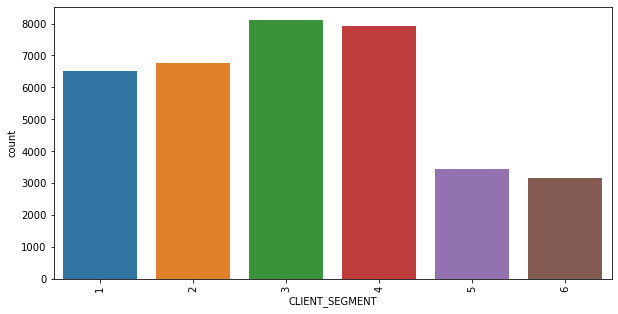

In [6]:
plt.figure(figsize = (10,5))
sns.countplot(data = train0, x = 'CLIENT_SEGMENT')
plt.xticks(rotation = 90)
plt.show()

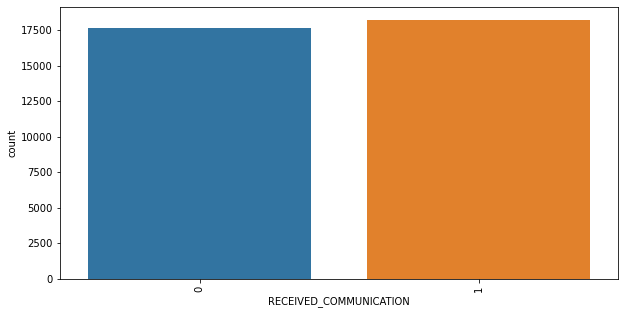

In [7]:
plt.figure(figsize = (10,5))
sns.countplot(data = train0, x = 'RECEIVED_COMMUNICATION')
plt.xticks(rotation = 90)
plt.show()

# Datos Test

In [8]:
test0.shape

(19, 4)

In [9]:
test0.head()

,CLIENT ID,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,48352078,"8,33",100,0
1,18072186,"93,42","186,83",1
2,48352246,"45,83","137,5",0
3,18070621,"16,67",200,1
4,48352262,"13,33",160,0


In [10]:
test0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CLIENT ID               19 non-null     int64 
 1   AVG CONSO               19 non-null     object
 2   AVG BASKET SIZE         19 non-null     object
 3   RECEIVED_COMMUNICATION  19 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 736.0+ bytes


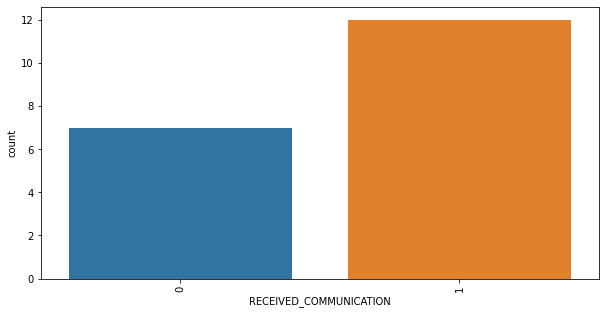

In [11]:
plt.figure(figsize = (10,5))
sns.countplot(data = test0, x = 'RECEIVED_COMMUNICATION')
plt.xticks(rotation = 90)
plt.show()

# Datos de ordenes

In [12]:
orders.shape

(66912, 4)

In [13]:
orders.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66912 entries, 0 to 66911
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CLIENT ID      66912 non-null  int64 
 1   NB PRODS       66912 non-null  int64 
 2   ORDER ID       66912 non-null  int64 
 3   FRUIT_PRODUCT  66912 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.0+ MB


In [15]:
orders.duplicated().sum()

616

In [16]:
orders = orders.drop_duplicates()

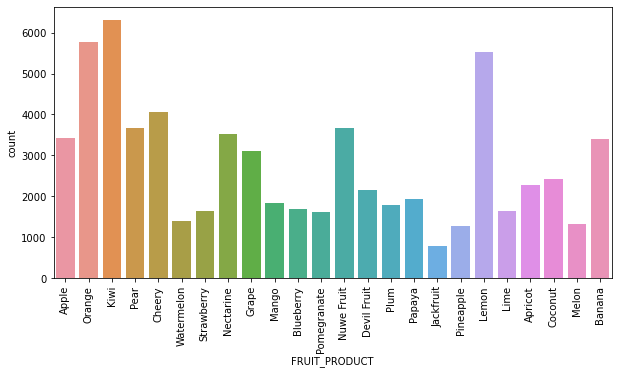

In [17]:
plt.figure(figsize = (10,5))
sns.countplot(data = orders, x = 'FRUIT_PRODUCT')
plt.xticks(rotation = 90)
plt.show()

In [18]:
orders.describe()

,CLIENT ID,NB PRODS,ORDER ID
count,66296.00,66296.00,66296.00
mean,26131168.85,4.54,672254208.52
std,8471058.31,5.80,3204864.21
min,18070505.00,-80.00,663833537.00
25%,20173789.25,1.00,669480518.00
50%,24378507.00,3.00,671997445.00
75%,25386797.25,5.00,675089321.00
max,48365861.00,198.00,683213167.00


In [19]:
def outliers_quantie(df, feature, param=1.5):  
        
    iqr_ = iqr(df[feature], nan_policy='omit')
    q1 = np.nanpercentile(df[feature], 25)
    q3 = np.nanpercentile(df[feature], 75)
    
    th1 = q1 - iqr_*1.5
    th2 = q3 + iqr_*1.5
    
    return df[(df[feature] >= th1) & (df[feature] <= th2)].reset_index(drop=True)

In [20]:
outliers_quantie(orders,'NB PRODS')

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery
...,...,...,...,...
61555,48352045,2,670065547,Pineapple
61556,48352045,1,670065547,Apple
61557,48352045,2,670065547,Watermelon
61558,48352045,1,670065547,Grape


# Combinando Train y Test

In [21]:
target = train0['CLIENT_SEGMENT']
test_id = test0["CLIENT ID"]

train1 = train0.drop(['CLIENT ID', 'CLIENT_SEGMENT'], axis=1)
test1 = test0.drop('CLIENT ID', axis=1)

data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)
data1

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,"67,25","201,75",0
1,"58,33",350,0
2,"46,67",112,0
3,50,600,0
4,10,120,0
...,...,...,...
35898,"154,83","109,29",1
35899,"33,33",400,1
35900,25,150,0
35901,"158,42","211,22",1


# Limpieza de datos

In [22]:
data2 = data1.copy()

## Verificando que los datos sean del tipo correcto

In [23]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35903 entries, 0 to 35902
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   AVG CONSO               35903 non-null  object
 1   AVG BASKET SIZE         35903 non-null  object
 2   RECEIVED_COMMUNICATION  35903 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 841.6+ KB


In [24]:
data2['AVG CONSO'] = data2['AVG CONSO'].astype(str)

In [25]:
data2['AVG BASKET SIZE'] = data2["AVG BASKET SIZE"].astype(str)

In [26]:
data2['AVG CONSO']=data2['AVG CONSO'].apply(lambda x: x.replace(',','.'))

In [27]:
data2['AVG BASKET SIZE'] = data2["AVG BASKET SIZE"].apply(lambda x: x.replace(',','.'))

In [28]:
data2['AVG CONSO'] = data2['AVG CONSO'].astype(float)

In [29]:
data2['AVG BASKET SIZE'] = data2["AVG BASKET SIZE"].astype(float)

In [30]:
data2.describe()

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
count,35903.00,35903.00,35903.00
mean,64.54,181.22,0.51
std,64.38,129.59,0.50
min,0.83,10.00,0.00
25%,20.83,100.00,0.00
50%,50.00,160.00,1.00
75%,88.21,225.00,1.00
max,2433.33,3400.20,1.00


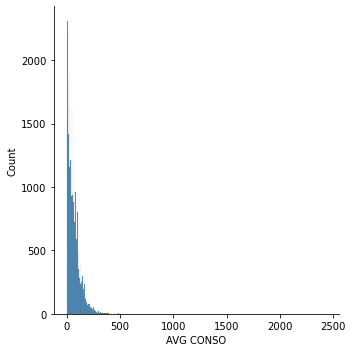

In [31]:
sns.displot(data2['AVG CONSO']);

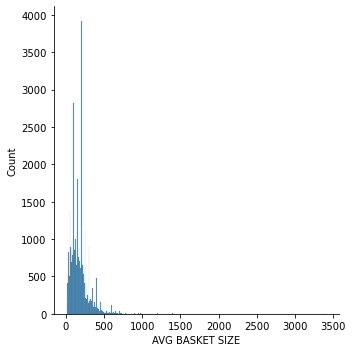

In [32]:
sns.displot(data2['AVG BASKET SIZE']);

In [33]:
skew_df = pd.DataFrame(data2.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data2[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,AVG CONSO,5.06,5.06,True
1,AVG BASKET SIZE,3.06,3.06,True
2,RECEIVED_COMMUNICATION,-0.03,0.03,False


In [34]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data2[column] = np.log(data2[column])

In [35]:
outliers_quantie(data2,['AVG CONSO','AVG BASKET SIZE', 'RECEIVED_COMMUNICATION'])

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,4.21,5.31,0
1,4.07,5.86,0
2,3.84,4.72,0
3,3.91,6.40,0
4,2.30,4.79,0
...,...,...,...
35898,5.04,4.69,1
35899,3.51,5.99,1
35900,3.22,5.01,0
35901,5.07,5.35,1


# Split Data

In [36]:
train_final = data2.loc[:train0.index.max(), :].copy()
test_final = data2.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [37]:
train_final

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,4.21,5.31,0
1,4.07,5.86,0
2,3.84,4.72,0
3,3.91,6.40,0
4,2.30,4.79,0
...,...,...,...
35879,2.53,5.01,1
35880,3.62,4.72,1
35881,3.73,4.83,1
35882,4.14,4.83,1


In [38]:
test_final

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,2.12,4.61,0
1,4.54,5.23,1
2,3.82,4.92,0
3,2.81,5.30,1
4,2.59,5.08,0
5,2.81,5.30,0
6,2.12,4.61,1
7,3.99,5.09,0
8,3.28,4.67,0
9,5.12,5.81,1


In [39]:
final_training_data = pd.concat([train_final, target], axis=1)

In [40]:
final_training_data

,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION,CLIENT_SEGMENT
0,4.21,5.31,0,6
1,4.07,5.86,0,2
2,3.84,4.72,0,3
3,3.91,6.40,0,2
4,2.30,4.79,0,4
...,...,...,...,...
35879,2.53,5.01,1,4
35880,3.62,4.72,1,3
35881,3.73,4.83,1,3
35882,4.14,4.83,1,3


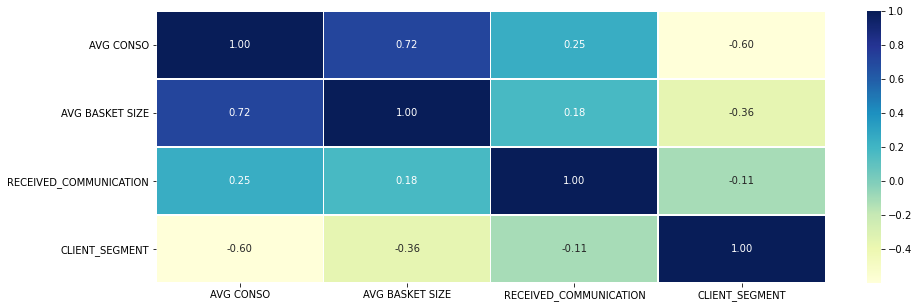

In [41]:
plt.figure(figsize=(15,5))
sns.heatmap(final_training_data.corr(),annot=True,cmap="YlGnBu", linewidths=.5,fmt='.2f')
plt.show()

In [42]:
X = final_training_data.drop(['CLIENT_SEGMENT'], axis = 1)
y = final_training_data['CLIENT_SEGMENT']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=final_training_data['CLIENT_SEGMENT'])

In [44]:
scaler = StandardScaler()

In [47]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [48]:
y_res.value_counts()

1    6498
2    6498
3    6498
4    6498
5    6498
6    6498
Name: CLIENT_SEGMENT, dtype: int64

In [54]:
x_res_st = scaler.fit_transform(X_res)

In [55]:
x_test_st = scaler.fit_transform(X_test)

In [56]:
test_final_st = scaler.fit_transform(test_final)

In [138]:
layers = [
    keras.layers.Dense(500, activation = 'relu',input_shape = X_res.shape[1:]),
    keras.layers.Dense(units = 300, activation='relu'),
    keras.layers.Dense(units = 200, activation='relu'),
    keras.layers.Dense(units = 50, activation='relu'),
    keras.layers.Dense(units = 7, activation='softmax')
]

model = keras.models.Sequential(layers)

In [139]:
print(model.layers[1])

In [140]:
from keras import backend as K

y_pred = model.predict(x_test_st)

def recall_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, y_pred):
    precision = precision_m(y_test, y_pred)
    recall = recall_m(y_test, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [141]:
from keras import metrics
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics=['acc'])


In [142]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("callback_model.h5")
history = model.fit(
    x_res_st,
    y_res,
    batch_size = 1000,
    epochs = 30,
    validation_data = (x_test_st, y_test),
    callbacks = [checkpoint_cb])

Epoch 1/30
39/39 [==============================] - 1s 21ms/step - loss: 1.1478 - acc: 0.5562 - val_loss: 0.7961 - val_acc: 0.7326
Epoch 2/30
39/39 [==============================] - 1s 19ms/step - loss: 0.7535 - acc: 0.7117 - val_loss: 0.7358 - val_acc: 0.7385
Epoch 3/30
39/39 [==============================] - 1s 15ms/step - loss: 0.7164 - acc: 0.7160 - val_loss: 0.7033 - val_acc: 0.7330
Epoch 4/30
39/39 [==============================] - 1s 15ms/step - loss: 0.7084 - acc: 0.7161 - val_loss: 0.6879 - val_acc: 0.7449
Epoch 5/30
39/39 [==============================] - 1s 15ms/step - loss: 0.6913 - acc: 0.7214 - val_loss: 0.7135 - val_acc: 0.7226
Epoch 6/30
39/39 [==============================] - 1s 14ms/step - loss: 0.6926 - acc: 0.7180 - val_loss: 0.7287 - val_acc: 0.7144
Epoch 7/30
39/39 [==============================] - 1s 15ms/step - loss: 0.6785 - acc: 0.7252 - val_loss: 0.6633 - val_acc: 0.7439
Epoch 8/30
39/39 [==============================] - 1s 16ms/step - loss: 0.6783 - a

In [143]:
acc_test = model.evaluate(x_test_st, y_test)
print(acc_test)

225/225 [==============================] - 0s 1ms/step - loss: 0.6902 - acc: 0.7401
[0.690155565738678, 0.7401421070098877]
